## SGSC Lava Inference - Loihi - fixed point

In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import numpy as np
from lava.proc.lif.process import LIFReset
from lava.proc.io.source import RingBuffer
from lava.proc.dense.process import Dense
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from matplotlib import pyplot as plt
from tqdm import tqdm
from lava.magma.core.process.process import LogConfig
import logging
from lava.utils.system import Loihi2
import os
from lava.proc.embedded_io.spike import PyToNxAdapter
from lava.proc.embedded_io.state import Read as StateReader
from lava.proc.io.sink import RingBuffer as SpikeOut
from lava.proc.io.sink import PyReceiveModelFixed
from lava.utils.loihi2_state_probes import StateProbe

import opendatasets as od
from SGSC_dataset_loader_padded_spikes import SGSC_Loader

def rescale_factor(w, bits):
    rng = float(2**(bits-1))
    mx = max(np.percentile(w,99), np.percentile(-w,99))
    fac = (rng-1)/mx
    mn = -(rng-2)/fac
    return (fac, mn, mx)

log_config = LogConfig("lava_SGSC.log")
log_config.level_console= logging.WARNING

params = {}
params["DT_MS"] = 1.0
params["TAU_MEM"] = 20.0
params["TAU_SYN"] = 2.0
params["num_samples"] = 1 #int(11005 / 8)
params["sample_id"] = 0     #sample used for graph generation (starting at 0, < num_samples)

params["NUM_INPUT"] = 80
params["NUM_HIDDEN"] = 512
params["NUM_OUTPUT"] = 35

params["timesteps"] = 2048

# toggle to record spikes, useful for debugging, but memory intensive
params["record_network_ih_activity"] =  True

os.environ["PATH"] += ":/nfs/ncl/bin:"
os.environ["PARTITION"] = "oheogulch_20m" # _2h (if 2 hours are needed)
os.environ['SLURM'] = '1'
os.environ['LOIHI_GEN'] = 'N3C1'

#os.environ['LOIHI_GEN'] = 'N3C1'
#os.environ['NOSLURM'] = '1'
#os.environ['NXSDKHOST'] = '10.1.23.175'
#os.environ['HOST_BINARY'] = '/opt/nxcore/bin/nx_driver_server'
#os.environ["PATH"] += ":/opt/riscv/bin/:"

loihi2_is_available = Loihi2.is_loihi2_available


if loihi2_is_available:
    print(f'Running on {Loihi2.partition}')
    from lava.utils import loihi2_profiler
else:
    RuntimeError("Loihi2 compiler is not available in this system. "
                 "This tutorial cannot proceed further.")

do_plots= True
weight_bits= 8

# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

x_train, y_train, x_test, y_test, x_validation, y_validation = SGSC_Loader(dir = os.getcwd() + "/spiking-google-speech-commands/",
                                                                           num_samples=params["num_samples"],
                                                                           shuffle = False,
                                                                           number_of_timesteps = params["timesteps"])

the_x = x_test
the_y = y_test

print(the_x[0].shape)

sample_image_start = the_x.shape[2] * params["sample_id"]
sample_image_end = (the_x.shape[2] * params["sample_id"]) + the_x.shape[2]

weight_bits= 8

# transform some parmeters
tau_mem_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_MEM"])
tau_mem_fac_int = int(np.round(tau_mem_fac*(2**12)))
tau_syn_fac = 1.0-np.exp(-params["DT_MS"]/params["TAU_SYN"])
tau_syn_fac_int = int(np.round(tau_syn_fac*(2**12)))

# load connections
w_i2h = np.load("SGSC_pretrained_weights/SGSC_Pop0_Pop1-g.npy")
w_i2h = w_i2h.reshape((params["NUM_INPUT"],
                       params["NUM_HIDDEN"])).T
w_i2h *= tau_mem_fac

w_h2h = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop1-g.npy")
w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                       params["NUM_HIDDEN"])).T
w_h2h *= tau_mem_fac

w_h2o = np.load("SGSC_pretrained_weights/SGSC_Pop1_Pop2-g.npy")
w_h2o = w_h2o.reshape((params["NUM_HIDDEN"],
                       params["NUM_OUTPUT"])).T
w_h2o *= tau_mem_fac

# weight scaling
w = np.hstack([w_i2h,w_h2h])
w_2h_fac, mn, mx = rescale_factor(w,weight_bits)
w_i2h[w_i2h > mx] = mx
w_i2h[w_i2h < mn] = mn
w_i2h_int = np.round(w_i2h*w_2h_fac).astype(np.int8)
print(f"i2h: mn == {np.amin(w_i2h_int)}, mx == {np.amax(w_i2h_int)}")

w_h2h[w_h2h > mx] = mx
w_h2h[w_h2h < mn] = mn
w_h2h_int = np.round(w_h2h*w_2h_fac).astype(np.int8)
print(f"h2h: mn == {np.amin(w_h2h_int)}, mx == {np.amax(w_h2h_int)}")

w_2o_fac, mn, mx = rescale_factor(w_h2o,weight_bits)
w_2o_fac /= 2.0
mn *= 2.0
mx *= 2.0
w_h2o[w_h2o > mx] = mx
w_h2o[w_h2o < mn] = mn
w_h2o_int = np.round(w_h2o*w_2o_fac).astype(np.int8)
print(f"h2o: mn == {np.amin(w_h2o_int)}, mx == {np.amax(w_h2o_int)}")

vth_hid = w_2h_fac
vth_hid_int = int(np.round(vth_hid))

the_x= np.hstack(the_x)
print(the_x.shape)

# Create processes
input = RingBuffer(data=the_x)

py2nx_inp = PyToNxAdapter(shape=(the_x.shape[0],))

hidden = LIFReset(shape=(params["NUM_HIDDEN"], ),                         # Number and topological layout of units in the process
                  vth=vth_hid_int,                             # Membrane threshold
                  dv=tau_mem_fac_int,                              # Inverse membrane time-constant
                  du=tau_syn_fac_int,                              # Inverse synaptic time-constant
                  bias_mant=0,           # Bias added to the membrane voltage in every timestep
                  name="hidden",
                  reset_interval=params["timesteps"],
                  log_config=log_config)

output = LIFReset(shape=(params["NUM_OUTPUT"], ),                         # Number and topological layout of units in the process
                  vth=2**30,                             # Membrane threshold
                  dv=tau_mem_fac_int,                              # Inverse membrane time-constant
                  du=tau_syn_fac_int,                              # Inverse synaptic time-constant
                  bias_mant=0,           # Bias added to the membrane voltage in every timestep
                  name="output",
                  reset_interval=params["timesteps"],
                  log_config=log_config)

in_to_hid = Dense(weights= w_i2h_int,     # Initial value of the weights, chosen randomly
                  name='in_to_hid')

hid_to_hid = Dense(weights=w_h2h_int,
                   name='hid_to_hid')

hid_to_out = Dense(weights=w_h2o_int,
                   name= 'hid_to_out')

input.s_out.connect(py2nx_inp.inp)
py2nx_inp.out.connect(in_to_hid.s_in)
in_to_hid.a_out.connect(hidden.a_in)
hidden.s_out.connect(hid_to_hid.s_in)
hidden.s_out.connect(hid_to_out.s_in)
hid_to_hid.a_out.connect(hidden.a_in)
hid_to_out.a_out.connect(output.a_in)

Running on oheogulch_20m
Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)
loading training


100%|██████████| 1/1 [00:00<00:00, 6232.25it/s]


loading testing


100%|██████████| 1/1 [00:00<00:00, 7002.18it/s]


loading validation


100%|██████████| 1/1 [00:00<00:00, 938.74it/s]

(80, 2048)
i2h: mn == -126, mx == 127
h2h: mn == -126, mx == 127
h2o: mn == -117, mx == 127
(80, 2048)


In [3]:
# probe recording
probe_v = StateProbe(output.v)

probe_input_s = StateProbe(hidden.v)

In [4]:
# monitor outputs
num_steps = int(params["timesteps"]/params["DT_MS"])

# run something
run_condition = RunSteps(num_steps=num_steps)

#loihi2hw_exception_map = {
#            SpikeOut: PyReceiveModelFixed,
#        }

run_cfg = Loihi2HwCfg(callback_fxs=[probe_v, probe_input_s])
output._log_config.level = logging.INFO

In [5]:
for i in tqdm(range(params["num_samples"])):
    output.run(condition=run_condition, run_cfg=run_cfg)

  0%|          | 0/1 [00:00<?, ?it/s]

Partitioning converged after iteration=4
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   3.20%|  12.50%|   0.85%|  38.40%|   0.22%|   0.00%|  33.63%|       1|
|   3.70%|  12.50%|   1.00%|  48.10%|   0.26%|   0.00%|  41.86%|      13|
|-----------------------------------------------------------------------|
| Total                                                        |      14|
-------------------------------------------------------------------------


/homes/ts468/lava_env/lib/python3.8/site-packages/nxcore/arch/n3b/n3board.py:54: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.185:37601
INFO:DRV:      Host server up..............Done 0.62s
INFO:DRV:      Mapping chipIds.............Done 0.02ms
INFO:DRV:      Mapping coreIds.............Done 0.14ms
INFO:DRV:      Partitioning neuron groups..Done 3.62ms
INFO:DRV:      Mapping axons...............Done 0.03s
INFO:DRV:      Configuring Spike Block.....Done 0.01ms
INFO:DRV:      Writes SpikeIO Config to FileDone 0.02ms
INFO:DRV:      Initializes Python MQ.......Done 0.00ms
INFO:DRV:      Partitioning MPDS...........Done 3.60ms
INFO:DRV:      Creating Embedded Snips and ChannelsDone 5.08ms
INFO:DRV:      Compiling Embedded snips....Done 0.57s
INFO:DRV:      Compiling Host snips........Done 0.16ms
INFO:DRV:      Compiling Register Probes...Done 0.01s
INFO:DRV:      Compiling Spike Probes......Done 0.01ms
INFO:HST:  Args chip=0 cpu=0 /homes/ts468/lava_env/lib/python3.8/site-packages/nxcore/arch/base/pre_execution/../../../../temp/86c4c7da-

100%|██████████| 1/1 [01:59<00:00, 119.78s/it]


In [6]:
print(probe_v.time_series[:num_steps])
output.stop()
output_v = probe_v.time_series.reshape(num_steps * params["num_samples"], params["NUM_OUTPUT"])

INFO:HST:  Execution has not started yet or has finished.
INFO:HST:  Stopping Execution : at 2048
INFO:HST:  chip=0 cpu=1 halted, status=0x0
INFO:HST:  chip=0 cpu=0 halted, status=0x0


[0 0 0 ... 0 0 0]


In [7]:
output_v.shape

(2048, 35)

In [8]:
probe_v.time_series

array([0, 0, 0, ..., 0, 0, 0])

In [9]:

good = 0
for i in range(params["num_samples"]):
    out_v = output_v[:,i*num_steps:(i+1)*num_steps]
    sum_v = np.sum(out_v,axis=1)
    pred = np.argmax(sum_v)
    print(f"prediction {pred} vs ground truth {the_y[i]}")
    if pred == the_y[i]:
        good += 1

print("test accuracy: ", good/params["num_samples"]*100)

prediction 0 vs ground truth 16
test accuracy:  0.0


In [10]:
params["record_network_ih_activity"] = True

In [11]:
output_v = probe_v.time_series.reshape(num_steps * params["num_samples"], params["NUM_OUTPUT"])
print(output_v.shape)


(2048, 35)


In [12]:
sample_image_end

2048

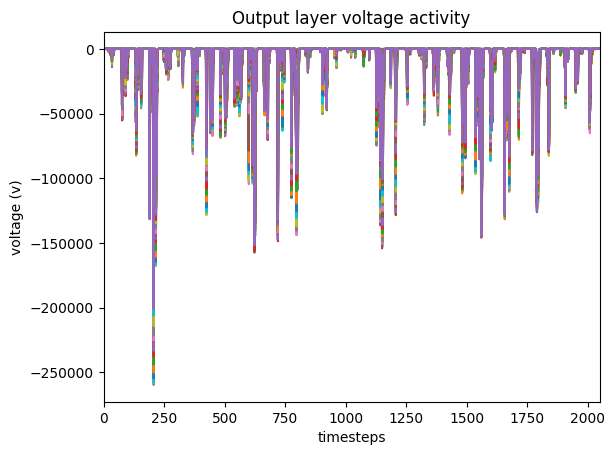

In [13]:
if params["record_network_ih_activity"]:
    output_v = probe_v.time_series.reshape(num_steps * params["num_samples"], params["NUM_OUTPUT"])

    single_image = output_v[sample_image_start:sample_image_end]

    for i in range(params["NUM_OUTPUT"]):
        plt.plot(single_image[:,i])

    plt.title("Output layer voltage activity")
    plt.ylabel("voltage (v)")
    plt.xlabel("timesteps")
    plt.xlim(0, the_x.shape[1] / params["num_samples"])
    plt.show()